# Analysis of IHC experiment data

This notebook contains code for running analysis of immunofluorescence/immunohistochemistry segmentation data processed from QuPath. The analysis is to check for intensities of key markers of mediators for the NSC proximity effect and the T cell proximity effect. Input files are the ouputs cell features from QuPath processing of the raw IHC images. This is an archival notebook.

**Associated manuscript figures/tables:**
- Figures: 5j,k,l,n

**Inputs required:**
- `data/IHC_qupath_outputs/NSC_measurements.csv` - QuPath cell segmentation measurement output file for the NSC staining panel across five young mice
- `data/IHC_qupath_outputs/NSC_actin_control_measurements.csv` - QuPath cell segmentation measurement output file for a control panel with Beta-actin for two young mice
- `data/IHC_qupath_outputs/TCell_measurements.csv` - QuPath cell segmentation measurement output file for the T cell staining panel across four old mice in Experiment 1
- `data/IHC_qupath_outputs/TCell_measurements2.csv` - QuPath cell segmentation measurement output file for the T cell staining panel across four old mice in Experiment 2 (8 mice in total across two experiments)

**Conda environment used**: `requirements/merfish.txt`

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import anndata as ad
from scipy.stats import pearsonr, spearmanr, ttest_ind, ttest_rel, wilcoxon, gaussian_kde
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.tri as tri
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set_style("ticks")
from sklearn.neighbors import BallTree

from scipy.stats import mannwhitneyu, ttest_ind
from statsmodels.stats.multitest import multipletests
from decimal import Decimal

In [2]:
def parse_filename (df, no_tcell=None):
    '''
    Parse filename and extract sample information
    '''
    # Get filenames from df
    filenames = df["Image"]
    
    # Parse out key fields
    animal_id = []
    slide_id = []
    section_id = []
    region_id = []
    
    for fn in filenames:
        split_fn = fn.split("_")
        animal_id.append(split_fn[0])
        slide_id.append(split_fn[1])
        section_id.append(split_fn[2])
        region_id.append(split_fn[3])
    
    # construct new dataframe columns
    df["animal"] = animal_id
    df["slide"] = slide_id
    df["section"] = section_id
    df["region"] = region_id
    
    # Extract additional T cell information    
    if no_tcell is not None:
        no_tcell = []
        for fn in filenames:
            if "no_tcell" in fn:
                no_tcell.append(True)
            else:
                no_tcell.append(False)
        df["no_tcell"] = no_tcell
    
    return (df)



def nearest_distance_to_positive (df, sub_id="Image", get_nearest_feature=False):
    '''
    Adapted from ageaccel_proximity.nearest_distance_to_celltype()
    '''        
    all_distances = np.ones(df.shape[0])*np.inf # default to very far
    if get_nearest_feature != False:
        nearest_features = np.ones(df.shape[0])*np.nan # default to nan
    
    for sid in np.unique(df[sub_id]):

        sub_df = df[df[sub_id]==sid]
                
        if np.sum(sub_df["Classification"]=="Positive") > 0: # skip no positive imgs

            # Subset into spatial coordinates
            spatial_targets = sub_df[sub_df["Classification"]=="Positive"][["Centroid X µm","Centroid Y µm"]].values
            spatial_all = sub_df[["Centroid X µm","Centroid Y µm"]].values
            
            if spatial_targets.shape[0] > 1:
                # Create a BallTree 
                tree = BallTree(spatial_targets, leaf_size=2)
                # Query the BallTree
                distances2, idxs = tree.query(spatial_all,  k=2)
                # replace self distances of zero with next closest
                distances = distances2[:,0].copy()
                secondary_distances = distances2[:,1].copy()
                distances[distances==0] = secondary_distances[distances==0] 
                all_distances[df[sub_id]==sid] = distances.flatten()
                # get nearest feats (if specified)
                if get_nearest_feature != False:
                    # get feats
                    target_feats = sub_df[sub_df["Classification"]=="Positive"][get_nearest_feature].values
                    # map feats
                    nidxs = idxs[:,0].copy()
                    secondary_idxs = idxs[:,1].copy()
                    nidxs[nidxs==0] = secondary_idxs[nidxs==0]
                    nfeats = [target_feats[ii] for ii in nidxs.flatten()]
                    nearest_features[df[sub_id]==sid] = nfeats
            
            else: # only one positive
                # Create a BallTree 
                tree = BallTree(spatial_targets, leaf_size=1)
                # Query the BallTree
                distances, idxs = tree.query(spatial_all,  k=1)
                distances = distances[:,0].flatten()
                # Replace zero (self) distances with inf
                distances[distances==0] = np.inf
                all_distances[df[sub_id]==sid] = distances
            
    # Update results
    df["distance_to_positive"] = all_distances
    
    # Update with nearest target features (if specified)
    if get_nearest_feature != False:
        df[f"nearest: {get_nearest_feature}"] = nearest_features
    
    return (df)

## NSC: CD9 colocalization analysis

In [27]:
# read and parse output from QuPath
df = pd.read_csv("data/IHC_qupath_outputs/NSC_measurements.csv")
df = parse_filename(df)

In [28]:
# name of feature to plot
measure = "Cell: CD9 mean"

In [29]:
print(df[df["Classification"]=="Negative"][measure].mean())
print(df[df["Classification"]=="Positive"][measure].mean())

4043.876526634423
5708.978750561331


In [30]:
print(df[df["Classification"]=="Negative"]["Cell: S100A6 mean"].mean())
print(df[df["Classification"]=="Positive"]["Cell: S100A6 mean"].mean())

1930.8650907104739
7791.272909126819


In [31]:
# aggregate across cells by sections and then by animals
gdf = df.groupby(["animal", "slide", "section", "Classification"])[[measure]].mean().reset_index()
gdf2 = gdf.groupby(["animal","Classification"])[[measure]].mean().reset_index()

# normalize by mean intensity of negative group
gdf2[measure] = gdf2[measure] / np.mean(gdf2[gdf2["Classification"]=="Negative"][measure])

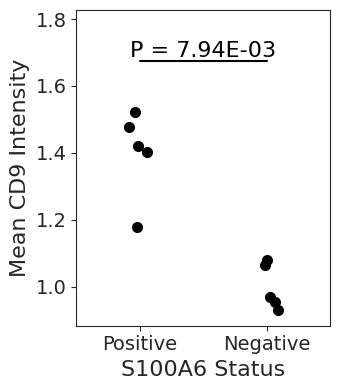

In [32]:
plot_df = gdf2
xlab = "Classification"
name = "NSC_CD9"


xtitle = "S100A6 Status"
ytitle = "Mean CD9 Intensity"

#------------------------------------------
fig, ax = plt.subplots(figsize=(3.5,4))

# statistical annotation
x_coords = [0.5]
y_coords = []
cols = ['k']*len(x_coords)
h = 0
w = 0.5
pval_labels = []
t,p = mannwhitneyu(plot_df[(plot_df[xlab]==np.unique(plot_df[xlab])[0])][measure], plot_df[(plot_df[xlab]==np.unique(plot_df[xlab])[1])][measure])
y_coords.append(1.1*np.max(plot_df[measure]))
pval_labels.append(p)
for i, label in enumerate(pval_labels):
    p_label = "P = "+ '%.2E' % Decimal(str(label))
    x1, x2, y, col = x_coords[i]-w, x_coords[i]+w, y_coords[i], cols[i]
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, p_label, ha='center', va='bottom', color=col, fontsize=16)
plt.ylim([np.min(plot_df[measure])-0.05*np.abs(np.min(plot_df[measure])),
            np.max(plot_df[measure])*1.2])

# plot
sns.stripplot(data = plot_df, x=xlab, y=measure, color='k', order=["Positive","Negative"], size=8, ax=ax)


plt.ylabel(ytitle, fontsize=16)
plt.xlabel(xtitle, fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
#plt.savefig(f"plots/ihc/{name}.pdf", bbox_inches='tight')
plt.show()

## NSC: CPT1A nearby cells

In [9]:
# read and parse output from QuPath
df = pd.read_csv("data/IHC_qupath_outputs/NSC_measurements.csv")
df = parse_filename(df)

In [10]:
# get cell proximities
df = nearest_distance_to_positive(df)

In [11]:
# define near cells
cutoff = 20

df["near_positive"] = ["Near" if x<cutoff else "Other" for x in df["distance_to_positive"]]

In [12]:
# name of feature to plot
measure = "Cell: CPT1A mean"

In [13]:
print(df[df["near_positive"]=="Near"][measure].mean())
print(df[df["near_positive"]=="Other"][measure].mean())

7621.686742569521
5700.148141795154


In [14]:
# aggregate across cells by sections and then by animals
gdf = df.groupby(["animal", "slide", "section", "near_positive"])[[measure]].mean().reset_index()
gdf2 = gdf.groupby(["animal","near_positive"])[[measure]].mean().reset_index()

# normalize by mean intensity of negative group
gdf2[measure] = gdf2[measure] / np.mean(gdf2[gdf2["near_positive"]=="Other"][measure])

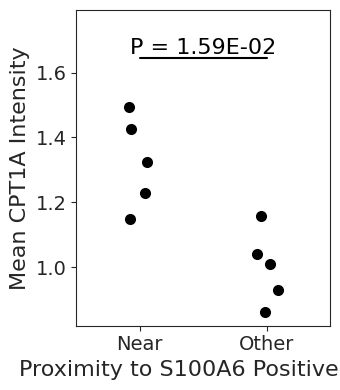

In [15]:
plot_df = gdf2
xlab = "near_positive"
name = "NSCnear_CPT1A"

xtitle = "Proximity to S100A6 Positive Cell"
ytitle = "Mean CPT1A Intensity"

#------------------------------------------
fig, ax = plt.subplots(figsize=(3.5,4))

# statistical annotation
x_coords = [0.5]
y_coords = []
cols = ['k']*len(x_coords)
h = 0
w = 0.5
pval_labels = []
t,p = mannwhitneyu(plot_df[(plot_df[xlab]==np.unique(plot_df[xlab])[0])][measure], plot_df[(plot_df[xlab]==np.unique(plot_df[xlab])[1])][measure])
y_coords.append(1.1*np.max(plot_df[measure]))
pval_labels.append(p)
for i, label in enumerate(pval_labels):
    p_label = "P = "+ '%.2E' % Decimal(str(label))
    x1, x2, y, col = x_coords[i]-w, x_coords[i]+w, y_coords[i], cols[i]
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, p_label, ha='center', va='bottom', color=col, fontsize=16)
plt.ylim([np.min(plot_df[measure])-0.05*np.abs(np.min(plot_df[measure])),
            np.max(plot_df[measure])*1.2])

# plot
sns.stripplot(data = plot_df, x=xlab, y=measure, color='k', order=["Near","Other"], size=8, ax=ax)

plt.ylabel(ytitle, fontsize=16)
plt.xlabel(xtitle, fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(f"plots/ihc/{name}.pdf", bbox_inches='tight')
plt.show()

## NSC: CD9 and CPT1A nearby cells

In [16]:
# read and parse output from QuPath
df = pd.read_csv("data/IHC_qupath_outputs/NSC_measurements.csv")
df = parse_filename(df)

In [17]:
# get cell proximities
df = nearest_distance_to_positive(df, get_nearest_feature="Cell: CD9 mean")

In [18]:
# define near cells
cutoff = 20

df["near_positive"] = ["Near" if x<cutoff else "Other" for x in df["distance_to_positive"]]

In [19]:
print(np.unique(df["near_positive"], return_counts=True))

(array(['Near', 'Other'], dtype=object), array([8990, 1816]))


In [20]:
# name of feature to plot
measure = "Cell: CPT1A mean"

In [21]:
# Subset to only near cells
df_excluded = df[(df["near_positive"]=="Near")].copy()

# normalize intensity by mean
df_excluded[measure] = df_excluded[measure] / df_excluded[measure].mean()
df_excluded["nearest: Cell: CD9 mean"] = df_excluded["nearest: Cell: CD9 mean"] / df_excluded["nearest: Cell: CD9 mean"].mean()

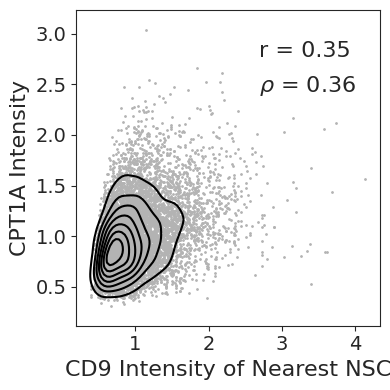

In [22]:
name = "NSCnear_CPT1A_correlate_nearestCD9"
offset = 0.1

#------------------

def density_estimation(m1, m2, offset):
    X, Y = np.mgrid[np.min(m1)-offset:np.max(m1)+offset:100j, np.min(m2)-offset:np.max(m2)+offset:100j]                                                     
    positions = np.vstack([X.ravel(), Y.ravel()])                                                       
    values = np.vstack([m1, m2])                                                                        
    kernel = gaussian_kde(values)                                                                 
    Z = np.reshape(kernel(positions).T, X.shape)
    return X, Y, Z

# compute correlations
r,p = pearsonr(df_excluded["nearest: Cell: CD9 mean"], df_excluded[measure])
rho,p = spearmanr(df_excluded["nearest: Cell: CD9 mean"], df_excluded[measure])

# make figure
plt.figure(figsize=(4,4))

# scatter
plt.scatter(df_excluded["nearest: Cell: CD9 mean"], df_excluded[measure], c='0.7', s=1, rasterized=True)

# contour
x, y, z = density_estimation(df_excluded["nearest: Cell: CD9 mean"], df_excluded[measure], offset=offset)
plt.contour(x, y, z, colors='k')

# annotate
plt.annotate(f"r = {round(r,2)}", (0.6, 0.85), xycoords='axes fraction', fontsize=16)
plt.annotate(fr"$\rho$ = {round(rho,2)}", (0.6, 0.74), xycoords='axes fraction', fontsize=16)


# plot
minsquarex = np.min(x)
maxsquarex = np.max(x)
minsquarey = np.min(y)
maxsquarey = np.max(y)
plt.xlim(minsquarex-offset, maxsquarex+offset)
plt.ylim(minsquarey-offset, maxsquarey+offset)
plt.ylabel("CPT1A Intensity", fontsize=16)
plt.xlabel("CD9 Intensity of Nearest NSC", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(f"plots/ihc/{name}.pdf", bbox_inches='tight', dpi=300)
plt.show()

## Negative control: NSC Proximity Beta-Actin Intensity

Using beta-actin as a negative control for proximity to NSC - 2 sections each for 2 brains

In [3]:
# read output from QuPath
df = pd.read_csv("data/IHC_qupath_outputs/NSC_actin_control_measurements.csv")

In [5]:
# parse file
animals = []
sections = []

for img in df["Image"]:
    animals.append(img.split("_")[1])
    sections.append(img.split("_")[2])

df["animal"] = animals
df["slide"] = "1"
df["section"] = sections

In [6]:
# get cell proximities
df = nearest_distance_to_positive(df)

In [7]:
# define near cells
cutoff = 50

df["near_positive"] = ["Near" if x<cutoff else "Other" for x in df["distance_to_positive"]]

In [10]:
# name of feature to plot
measure = "Cell: Beta-Actin mean"

In [11]:
# aggregate across cells by sections and then by animals
gdf = df.groupby(["animal", "slide", "section", "near_positive"])[[measure]].mean().reset_index()
gdf2 = gdf.groupby(["animal","near_positive"])[[measure]].mean().reset_index()

# normalize by mean intensity of negative group
gdf2[measure] = gdf2[measure] / np.mean(gdf2[gdf2["near_positive"]=="Other"][measure])

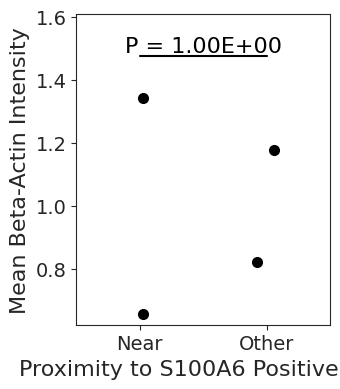

In [13]:
plot_df = gdf2
xlab = "near_positive"
name = "NSCnear_Bactin"

xtitle = "Proximity to S100A6 Positive Cell"
ytitle = "Mean Beta-Actin Intensity"

#------------------------------------------
fig, ax = plt.subplots(figsize=(3.5,4))

# statistical annotation
x_coords = [0.5]
y_coords = []
cols = ['k']*len(x_coords)
h = 0
w = 0.5
pval_labels = []
t,p = mannwhitneyu(plot_df[(plot_df[xlab]==np.unique(plot_df[xlab])[0])][measure], plot_df[(plot_df[xlab]==np.unique(plot_df[xlab])[1])][measure])
y_coords.append(1.1*np.max(plot_df[measure]))
pval_labels.append(p)
for i, label in enumerate(pval_labels):
    p_label = "P = "+ '%.2E' % Decimal(str(label))
    x1, x2, y, col = x_coords[i]-w, x_coords[i]+w, y_coords[i], cols[i]
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, p_label, ha='center', va='bottom', color=col, fontsize=16)
plt.ylim([np.min(plot_df[measure])-0.05*np.abs(np.min(plot_df[measure])),
            np.max(plot_df[measure])*1.2])

# plot
sns.stripplot(data = plot_df, x=xlab, y=measure, color='k', order=["Near","Other"], size=8, ax=ax)

plt.ylabel(ytitle, fontsize=16)
plt.xlabel(xtitle, fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(f"plots/ihc/{name}.pdf", bbox_inches='tight')
plt.show()

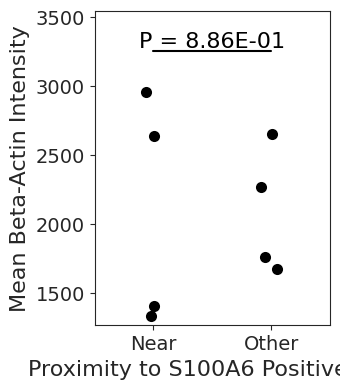

In [14]:
plot_df = gdf
xlab = "near_positive"
name = "NSCnear_Bactin"

xtitle = "Proximity to S100A6 Positive Cell"
ytitle = "Mean Beta-Actin Intensity"

#------------------------------------------
fig, ax = plt.subplots(figsize=(3.5,4))

# statistical annotation
x_coords = [0.5]
y_coords = []
cols = ['k']*len(x_coords)
h = 0
w = 0.5
pval_labels = []
t,p = mannwhitneyu(plot_df[(plot_df[xlab]==np.unique(plot_df[xlab])[0])][measure], plot_df[(plot_df[xlab]==np.unique(plot_df[xlab])[1])][measure])
y_coords.append(1.1*np.max(plot_df[measure]))
pval_labels.append(p)
for i, label in enumerate(pval_labels):
    p_label = "P = "+ '%.2E' % Decimal(str(label))
    x1, x2, y, col = x_coords[i]-w, x_coords[i]+w, y_coords[i], cols[i]
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, p_label, ha='center', va='bottom', color=col, fontsize=16)
plt.ylim([np.min(plot_df[measure])-0.05*np.abs(np.min(plot_df[measure])),
            np.max(plot_df[measure])*1.2])

# plot
sns.stripplot(data = plot_df, x=xlab, y=measure, color='k', order=["Near","Other"], size=8, ax=ax)

plt.ylabel(ytitle, fontsize=16)
plt.xlabel(xtitle, fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(f"plots/ihc/{name}_sections.pdf", bbox_inches='tight')
plt.show()

## T cell: STAT1 nearby cells

In [26]:
# read and parse output from QuPath

# first experiment
df = pd.read_csv("data/IHC_qupath_outputs/TCell_measurements.csv")

# second experiment
df2 = pd.read_csv("data/IHC_qupath_outputs/TCell_measurements2.csv")
df2["Image"] = ["b2"+x for x in df2["Image"]]

# combine

df = pd.concat((df,df2))

df = parse_filename(df, no_tcell="no_tcell")

In [27]:
# region_mapper

region_mapper = {"L":"VEN",
                 "R":"VEN",
                 "SVZ":"VEN",
                 "svz":"VEN",
                 "cc":"CC",
                 "meninges":"CTX",
                 "cortex":"CTX",
                 "striatum":"STR"}

df["region"] = [region_mapper[x] for x in df["region"]]

In [28]:
# get cell proximities
df = nearest_distance_to_positive(df)

In [29]:
# define near cells
cutoff = 50

df["near_positive"] = ["Near" if x<cutoff else "Other" for x in df["distance_to_positive"]]

In [7]:
# name of feature to plot
measure = "Cell: STAT1 mean"

In [9]:
# exclude T cells since they have STAT1
df = df[df["Classification"]=="Negative"]

In [10]:
print(df[df["near_positive"]=="Near"][measure].mean())
print(df[df["near_positive"]=="Other"][measure].mean())

3124.15443971979
2135.0597931899483


In [11]:
print(df[df["no_tcell"]==True][measure].mean())
print(df[df["no_tcell"]==False][measure].mean())

1861.328447021497
2417.257808332857


In [14]:
# aggregate across cells by sections and then by animals
gdf = df.groupby(["animal", "slide", "section", "near_positive"])[[measure]].mean().reset_index()
gdf2 = gdf.groupby(["animal","near_positive"])[[measure]].mean().reset_index()

# normalize by mean intensity of negative group
exp1_mean = np.mean(gdf2[(gdf2["near_positive"]=="Other")&~(gdf2["animal"].str.contains("b"))][measure])
exp2_mean = np.mean(gdf2[(gdf2["near_positive"]=="Other")&(gdf2["animal"].str.contains("b"))][measure])

normalized_measure = gdf2[measure].values.copy()

normalized_measure[~(gdf2["animal"].str.contains("b"))] = normalized_measure[~(gdf2["animal"].str.contains("b"))] / exp1_mean
normalized_measure[(gdf2["animal"].str.contains("b"))] = normalized_measure[(gdf2["animal"].str.contains("b"))] / exp2_mean

gdf2[measure] = normalized_measure

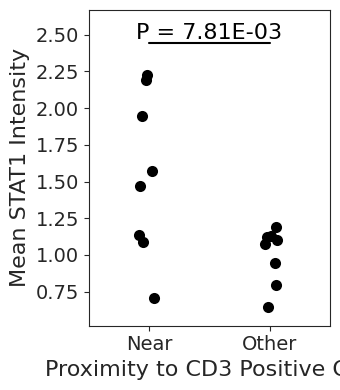

In [15]:
plot_df = gdf2
xlab = "near_positive"
name = "TCellnear_STAT1"

xtitle = "Proximity to CD3 Positive Cell"
ytitle = "Mean STAT1 Intensity"

#------------------------------------------
fig, ax = plt.subplots(figsize=(3.5,4))

# statistical annotation
x_coords = [0.5]
y_coords = []
cols = ['k']*len(x_coords)
h = 0
w = 0.5
pval_labels = []
t,p = wilcoxon(plot_df[(plot_df[xlab]==np.unique(plot_df[xlab])[0])][measure], plot_df[(plot_df[xlab]==np.unique(plot_df[xlab])[1])][measure])
y_coords.append(1.1*np.max(plot_df[measure]))
pval_labels.append(p)
for i, label in enumerate(pval_labels):
    p_label = "P = "+ '%.2E' % Decimal(str(label))
    x1, x2, y, col = x_coords[i]-w, x_coords[i]+w, y_coords[i], cols[i]
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, p_label, ha='center', va='bottom', color=col, fontsize=16)
plt.ylim([np.min(plot_df[measure])-0.2*np.abs(np.min(plot_df[measure])),
            np.max(plot_df[measure])*1.2])

# plot
sns.stripplot(data = plot_df, x=xlab, y=measure, color='k', order=["Near","Other"], size=8, ax=ax)


plt.ylabel(ytitle, fontsize=16)
plt.xlabel(xtitle, fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(f"plots/ihc/{name}.pdf", bbox_inches='tight')
plt.show()

In [17]:
gdf = df.groupby(["animal", "slide", "section", "region", "near_positive"])[[measure]].mean().reset_index()
gdf2 = gdf.groupby(["animal","region","near_positive"])[[measure]].mean().reset_index()
gdf2 = gdf2.groupby(["animal","region"]).filter(lambda x: len(x) >= 2).reset_index()

# normalize by mean intensity of negative group
exp1_mean = np.mean(gdf2[(gdf2["near_positive"]=="Other")&~(gdf2["animal"].str.contains("b"))][measure])
exp2_mean = np.mean(gdf2[(gdf2["near_positive"]=="Other")&(gdf2["animal"].str.contains("b"))][measure])

normalized_measure = gdf2[measure].values.copy()

normalized_measure[~(gdf2["animal"].str.contains("b"))] = normalized_measure[~(gdf2["animal"].str.contains("b"))] / exp1_mean
normalized_measure[(gdf2["animal"].str.contains("b"))] = normalized_measure[(gdf2["animal"].str.contains("b"))] / exp2_mean

gdf2[measure] = normalized_measure

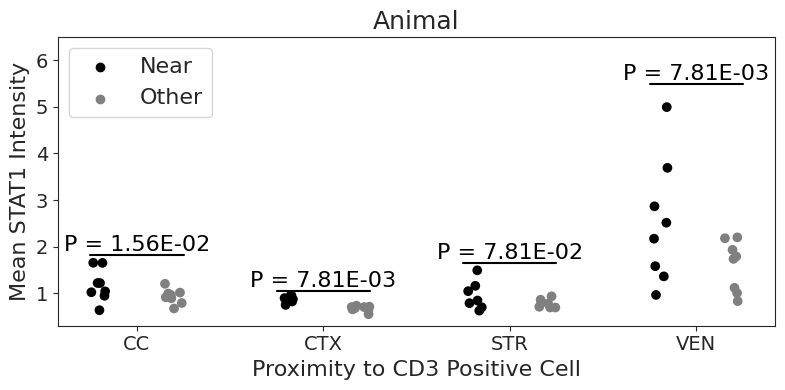

In [20]:
plot_df = gdf2
sep_by = "region" # actually x ticks
xlab = "near_positive" # actually hue
name = "TCellnear_STAT1_byregion_animals"

xtitle = "Proximity to CD3 Positive Cell"
ytitle = "Mean STAT1 Intensity"

# BY SECTIONS
plt.figure(figsize=(8,4))
plt.title("Animal", fontsize=18)

#----------------------------

sns.stripplot(data = plot_df, x=sep_by, y=measure, hue=xlab, dodge=True,
              hue_order=["Near","Other"], order=["CC","CTX","STR","VEN"],
              palette={"Near":"k","Other":"0.5"},
              size=7)

# statistical annotation
x_coords = [0, 1, 2, 3, 4]
y_coords = []
cols = ['k']*len(x_coords)
h = 0
w = 0.25
pval_labels = []
for ss in np.unique(plot_df[sep_by]):
    t,p = wilcoxon(plot_df[(plot_df[sep_by]==ss)&(plot_df[xlab]==np.unique(plot_df[xlab])[0])][measure], plot_df[(plot_df[sep_by]==ss)&(plot_df[xlab]==np.unique(plot_df[xlab])[1])][measure])
    y_coords.append(1.1*np.max(plot_df[(plot_df[sep_by]==ss)][measure]))
    pval_labels.append(p)
for i, label in enumerate(pval_labels):
    p_label = "P = "+ '%.2E' % Decimal(str(label))
    x1, x2, y, col = x_coords[i]-w, x_coords[i]+w, y_coords[i], cols[i]
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    plt.text((x1+x2)*.5, y+h, p_label, ha='center', va='bottom', color=col, fontsize=16)
plt.ylim([None,
            np.max(plot_df[measure])*1.3])

# plot
plt.legend(loc='best', fontsize=16)
plt.ylabel(ytitle, fontsize=16)
plt.xlabel(xtitle, fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig(f"plots/ihc/{name}.pdf", bbox_inches='tight')
plt.show()